<a href="https://colab.research.google.com/github/Praveen76/Image-Segmentation-using-U-Net-Model/blob/main/Image_Segmentation_using_UNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives:

At the end of the experiment, you will be able to:

*  understand, prepare, and visualize the the dataset containing image and corresponding masked image used for segmentation
*  understand the encoder, bottleneck, and decoder region of a U-Net architecture
*  build and train a U-Net architecture for segmentation
*  create a masked image (prediction)
*  calculate the accuracy score like IoU and Dice-Score used in segmentation
* understand and implement DeeplabV3+ architecture for segmentation

## Dataset
We will be training the model on the [Oxford Pets - IIIT](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset. This contains pet images, their classes, segmentation masks, and head region of interest. We will only use the images and segmentation masks for this experiment.

The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding label and pixel-wise masks. The masks are class labels for each pixel. Each pixel is given one of three categories:

* Class 1: Pixel belonging to the pet.
* Class 2: Pixel bordering the pet.
* Class 3: None of the above/a surrounding pixel.

### Import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

The dataset is already included in TensorFlow Datasets and you can simply download it. The segmentation masks are included in versions 3 and above. The cell below will download the dataset and place the results in a dictionary named dataset. It will also collect information about the dataset and we'll assign it to a variable named info. [Reference](https://www.tensorflow.org/tutorials/images/segmentation)

In [2]:
# Download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTJ76WA/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTJ76WA/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


### Understanding the downloaded dataset

In [3]:
print(type(dataset), type(info))

<class 'dict'> <class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>


In [4]:
# see the possible keys we can access in the dataset dict.
# this contains the test and train splits.
print(dataset.keys())
# see information about the dataset
print(info)

dict_keys(['train', 'test'])
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpts13i664tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=

In [5]:
info.splits['test'].num_examples

3669

In [6]:
info.splits['train'].num_examples

3680

### Prepare the Dataset
We will now prepare the train and test sets. The following utility functions preprocess the data. These include:

* simple augmentation by flipping the image
* normalizing the pixel values
* resizing the images

Another preprocessing step is to adjust the segmentation mask's pixel values. The README in the annotations folder of the dataset mentions that the pixels in the segmentation mask are labeled as such > {Class : Label} --> { 'foreground' : 1, 'background' : 2 , 'Not Classified' : 3 }.

The image color values are normalized to the [0, 1] range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2} and we will interpret these as {'pet', 'background', 'outline'}:

In [7]:
# Preprocessing Utilities

def random_flip(input_image, input_mask):
  '''does a random flip of the image and mask'''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  '''
  normalizes the input image pixel values to be from [0,1].
  subtracts 1 from the mask labels to have a range from [0,2]
  '''
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  '''resizes, normalizes, and flips the training data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def load_image_test(datapoint):
  '''resizes and normalizes the test data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

We can now call the utility functions above to prepare the train and test sets. The dataset you downloaded from TFDS already contains these splits and you will use those by simpling accessing the train and test keys of the dataset dictionary.

Note: The tf.data.experimental.AUTOTUNE you see in this notebook is simply a constant equal to -1. This value is passed to allow certain methods to automatically set parameters based on available resources. For instance, num_parallel_calls parameter below will be set dynamically based on the available CPUs. The docstrings will show if a parameter can be autotuned. Here is the entry describing what it does to num_parallel_calls.

In [8]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

### Visualize

In [9]:
for image, mask in train.take(10):
  sample_image, sample_mask = image, mask

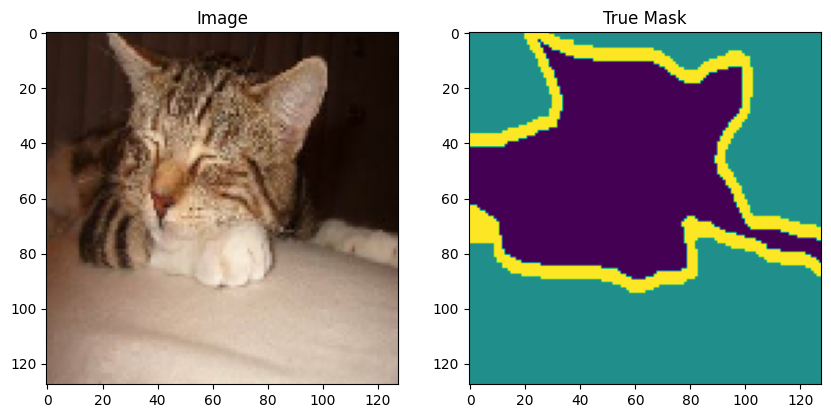

In [10]:
plt.figure(figsize=(10, 10))
img_arr = tf.keras.preprocessing.image.array_to_img(sample_image)
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(img_arr)

img_arr = tf.keras.preprocessing.image.array_to_img(sample_mask)
plt.subplot(1, 2, 2)
plt.title("True Mask")
plt.imshow(img_arr)


Now that the splits are loaded, you can then prepare batches for training and testing.

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

### Visualizations

In [12]:
sample_batch = next(iter(test_dataset))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]

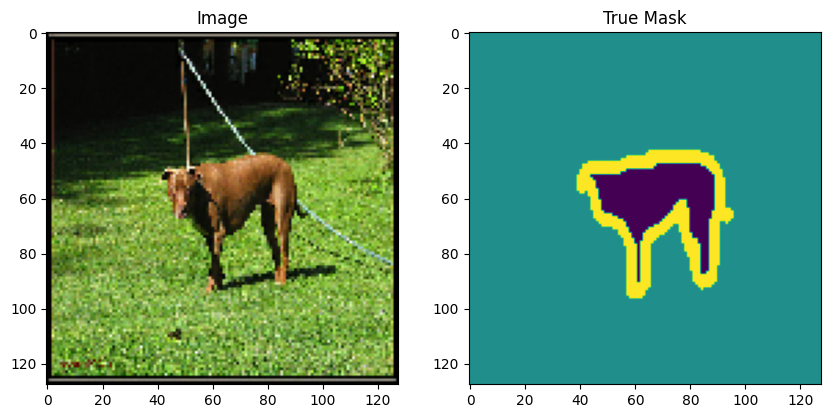

In [13]:
plt.figure(figsize=(10, 10))
img_arr = tf.keras.preprocessing.image.array_to_img(sample_image)
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(img_arr)

img_arr = tf.keras.preprocessing.image.array_to_img(sample_mask)
plt.subplot(1, 2, 2)
plt.title("True Mask")
plt.imshow(img_arr)

## **Implement the U-Net model**
Define model : With the dataset prepared, we can now build the UNet. Here is the overall architecture as shown below. A U-Net consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

<center>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/U-Net.png" width=800px height=500px/>
</center>
<br><br>



## Encoder
The encoder is having repeating blocks. It's best to create functions for it to make the code modular. These encoder blocks contain two Conv2D layers activated by ReLU, followed by a MaxPooling and Dropout layer. Each stage has an increasing number of filters and the dimensionality of the features reduce because of the pooling layer.

### Creating Encoder utilities with the following three functions:

* conv2d_block() - to add two convolution layers and ReLU activations
* encoder_block() - to add pooling and dropout to the conv2d blocks. Recall that in UNet, you need to save the output of the convolution layers at each block so this function will return two values to take that into account (i.e. output of the conv block and the dropout)
* encoder() - to build the entire encoder. This will return the output of the last encoder block as well as the output of the previous conv blocks. These will be concatenated to the decoder blocks as you'll see later.

In [14]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

### Bottleneck
A bottleneck follows the encoder block and is used to extract more features. This does not have a pooling layer so the dimensionality remains the same. You can use the conv2d_block() function defined earlier to implement this.

In [15]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

## Decoder
Finally, we have the decoder which upsamples the features back to the original image size. At each upsampling level, you will take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

### Creating Decoder  utilities with the following two functions:

In [16]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks.

  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs


### Putting it all together
We can finally build the UNet by chaining the encoder, bottleneck, and decoder. We will specify the number of output channels and in this particular set, that would be 3. That is because there are three possible labels for each pixel: 'pet', 'background', and 'outline'.

In [17]:
OUTPUT_CHANNELS = 3

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['activation[0][0]']          
                                                                                              

In [18]:
# tf.keras.utils.plot_model(model, show_shapes=False)

### Compile and Train the model
Now, all that is left to do is to compile and train the model. The loss we will use is sparse_categorical_crossentropy. The reason is that the network is trying to assign each pixel a label, just like a multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class and sparse_categorical_crossentropy is the recommended loss for such a scenario.

In [19]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# configure the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 1
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

57/57 [==============================] - 106s 1s/step - loss: 0.9233 - accuracy: 0.5883 - val_loss: 0.8947 - val_accuracy: 0.5737


We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

#### Learning curve from model history

In [21]:
def display_learning_curves(model_history):
  acc = model_history.history["accuracy"]
  val_acc = model_history.history["val_accuracy"]
  loss = model_history.history["loss"]
  val_loss = model_history.history["val_loss"]
  epochs_range = range(EPOCHS)

  fig = plt.figure(figsize=(8,5))

  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label="train accuracy")
  plt.plot(epochs_range, val_acc, label="validataion accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="train loss")
  plt.plot(epochs_range, val_loss, label="validataion loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  fig.tight_layout()
  plt.show()

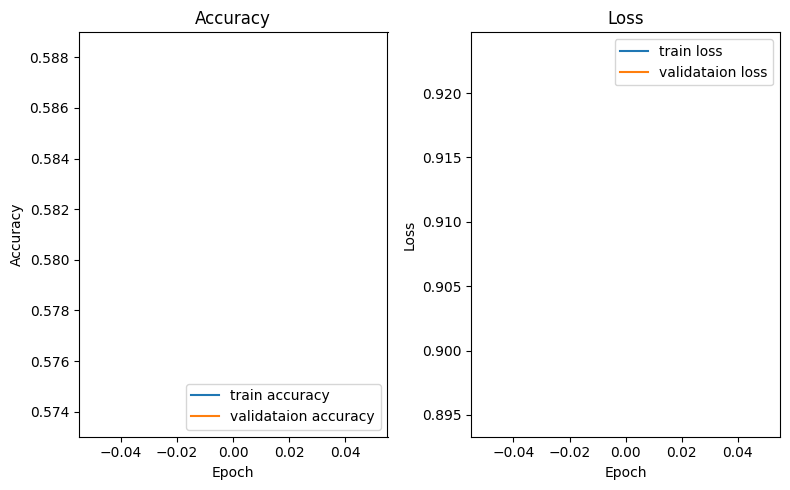

In [22]:
# Display learning curves
display_learning_curves(model_history)

### Make predictions
The model is now ready to make some predictions. We will use the test dataset prepared earlier to feed input images that the model has not seen before. The utilities below will help in processing the test dataset and model predictions.

In [23]:
# Few calculations that are being used inside utilities functions
print(info.splits['test'].num_examples)
print(BATCH_SIZE)
print(info.splits['test'].num_examples % BATCH_SIZE)
print((info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE)))
3648/64

3669
64
21
3648


57.0

### Prediction Utilities

In [24]:
def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''
  images = []
  y_true_segments = []
  for image, annotation in test:
    y_true_segments.append(annotation.numpy())
    images.append(image.numpy())

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

In [25]:
def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()

In [26]:
def make_predictions(image, mask, num=1, model = model):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [27]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to the model to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

57/57 [==============================] - 16s 277ms/step


## Compute class-wise metrics:  IOU and Dice Score
* **Intersection over union (IoU)**: It is known to be a good metric for measuring overlap between two bounding boxes or masks[Ground truth mask vs predicted mask]. If the prediction is completely correct, IoU = 1. The lower the IoU, the worse the prediction result.
<center>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/IoU.jpg" width=400px height=200px/>
</center>
<br><br>

* **Dice score/coefficient**: It can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth.
The Dice coefficient is 2 times The area of Overlap divided by the total number of pixels in both images.

<center>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dice_score.jpg" width=450px height=200px/>
</center>
<br><br>

In [28]:
# Function to compute class wise IoU and Dice score for a single test image and its prediction

def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001
    for i in range(3):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + 2 * smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

With the utility function defined above, calculating the metrics:

In [29]:
# Compute the class wise metrics for all test images
cls_wise_iou_scores = []
cls_wise_dice_scores = []
for i in range(len(y_true_segments)):
    iou, dice = class_wise_metrics(y_true_segments[i], results[i])
    cls_wise_iou_scores.append(iou)
    cls_wise_dice_scores.append(dice)

# Take average to get the final result over the test set
cls_wise_iou = np.array(cls_wise_iou_scores).mean(axis=0).round(2)
cls_wise_dice_score = np.array(cls_wise_dice_scores).mean(axis=0).round(2)

In [30]:
# show the IOU for each class
class_names = ["pet", "background", "outline"]

for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

pet         0.0 
background  0.58 
outline     0.0 


In [31]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))

pet         0.01 
background  0.71 
outline     0.0 


### Show Predictions

In [32]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 360

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider], model = model)

1/1 [==============================] - 1s 1s/step


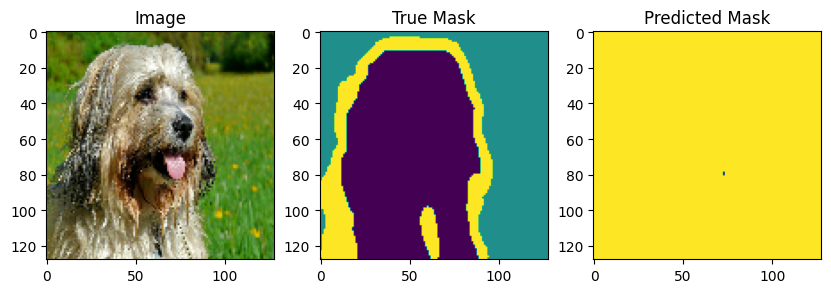

In [33]:
plt.figure(figsize=(10, 10))
# Original Image
img_arr = tf.keras.preprocessing.image.array_to_img(y_true_images[integer_slider])
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img_arr)

# Ground truth Mask
img_arr = tf.keras.preprocessing.image.array_to_img(y_true_segments[integer_slider])
plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(img_arr)
 # Predicted Mask
img_arr = tf.keras.preprocessing.image.array_to_img(y_pred_mask )
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(img_arr)

In [34]:
# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)
iou, dice_score

([0.00026784652435001135, 0.3802954465997464, 3.7216226136151003e-09],
 [0.0005355496036000813, 0.551034849149978, 7.443245199529251e-09])

## **Implement DeepLabV3+**

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregates context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate (d)***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution. Only the pink ones will be consider, green ones will be ignored.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dilated_Conv.jpg" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_diagram.png" >
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

For our model, we use the below architecture.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

As we use ResNet-50 as the backbone network, let's check the different layers present in it.

In [35]:
# Create ResNet-50 architecture for explore purpose
res_input = keras.Input(shape=(128, 128, 3))
resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor = res_input)

# Layers present in ResNet-50 network
resnet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

From the above layers,

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.



Let's create a function, `convolution_block()`, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [36]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                      padding="same", use_bias=use_bias,
                      kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

Create another function to perform Dilated Spatial Pyramid Pooling. Use above function to add different convolution blocks.

In [37]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape

    # 1x1 Conv rate=1
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    # 3x3 Conv rate=6
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    # 3x3 Conv rate=12
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    # 3x3 Conv rate=18
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    # Image pooling
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size = (dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation = "bilinear")(x)

    # Concat
    resultant = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])

    return resultant


### Create Encoder

Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the `conv4_block6_2_relu` layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [38]:
def Encoder(model_input):
    # Backbone network
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    # Features from backbone network to fead in DSPP
    x = resnet50.get_layer("conv4_block6_2_relu").output
    # DSPP module
    concat_out = DilatedSpatialPyramidPooling(x)
    # 1x1 Conv
    output = convolution_block(concat_out, kernel_size=1)

    return resnet50, output


### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the `conv2_block3_2_relu` layer) from the network backbone that have the same spatial resolution.


In [39]:
def Decoder(image_size, back_network, x):
    # Output from Encoder, upsample by 4
    input_a = layers.UpSampling2D(size = (image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
                                  interpolation = "bilinear")(x)
    # Low-level features from backbone network
    input_b = back_network.get_layer("conv2_block3_2_relu").output
    # Add 1x1 Conv on low-level features
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    # Concat
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    # Add 3x3 Conv blocks
    x = convolution_block(x)
    x = convolution_block(x)

    # Resultant upsample by 4
    output = layers.UpSampling2D(size = (image_size // x.shape[1], image_size // x.shape[2]),
                            interpolation = "bilinear")(x)
    return output


### Create Model

Create a function to implement DeepLabV3+ architecture.

In [40]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    # Encoder part
    back_network, x = Encoder(model_input)
    # Decoder part
    x = Decoder(image_size, back_network, x)

    # Output/prediction layer
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

    return keras.Model(inputs=model_input, outputs=model_output)


In [41]:
# Create model
deeplab_model = DeeplabV3Plus(image_size = 128, num_classes = 3)
deeplab_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

### Training

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

In [42]:
# Compile model
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
deeplab_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                      loss = loss,
                      metrics = ["accuracy"])

In [43]:
# configure the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 2
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

deeplab_model_history = deeplab_model.fit(train_dataset, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_steps=VALIDATION_STEPS,
                                          validation_data=test_dataset)

Epoch 1/2
57/57 [==============================] - 68s 477ms/step - loss: 0.4035 - accuracy: 0.8429 - val_loss: 119.2035 - val_accuracy: 0.3214
Epoch 2/2
57/57 [==============================] - 34s 456ms/step - loss: 0.2606 - accuracy: 0.8982 - val_loss: 2.3111 - val_accuracy: 0.5733


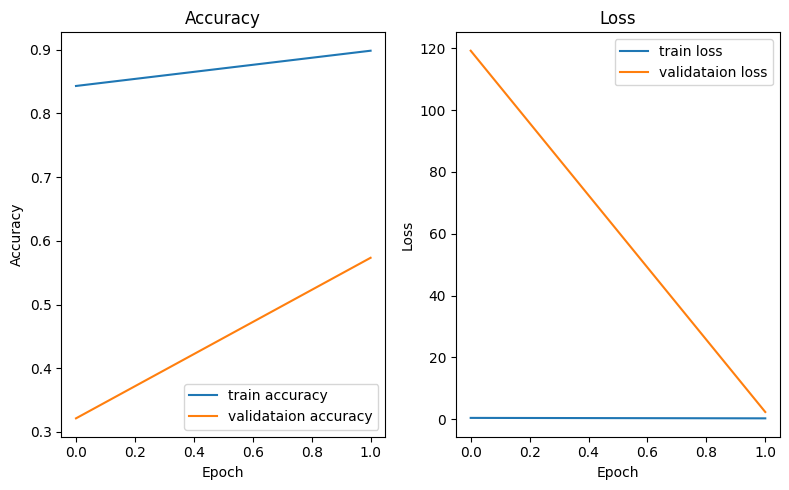

In [44]:
# Display learning curves
display_learning_curves(deeplab_model_history)

In [45]:
# Setup the predictions

# feed the test set to the deeplab model to get the predicted masks
deeplab_results = deeplab_model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
deeplab_results = np.argmax(deeplab_results, axis=3)
deeplab_results = deeplab_results[..., tf.newaxis]

57/57 [==============================] - 14s 223ms/step


### Calculate the metrics

In [46]:
# Compute the class wise metrics for all test images
deeplab_cls_wise_iou_scores = []
deeplab_cls_wise_dice_scores = []
for i in range(len(y_true_segments)):
    iou, dice = class_wise_metrics(y_true_segments[i], deeplab_results[i])
    deeplab_cls_wise_iou_scores.append(iou)
    deeplab_cls_wise_dice_scores.append(dice)

# Take average to get the final result over the test set
deeplab_cls_wise_iou = np.array(deeplab_cls_wise_iou_scores).mean(axis=0).round(2)
deeplab_cls_wise_dice_score = np.array(deeplab_cls_wise_dice_scores).mean(axis=0).round(2)

In [47]:
# show the IOU for each class
class_names = ["pet", "background", "outline"]

for idx, iou in enumerate(deeplab_cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

pet         0.0 
background  0.58 
outline     0.0 


In [48]:
# show the Dice Score for each class
for idx, dice_score in enumerate(deeplab_cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))

pet         0.0 
background  0.71 
outline     0.0 


### Compare with UNet

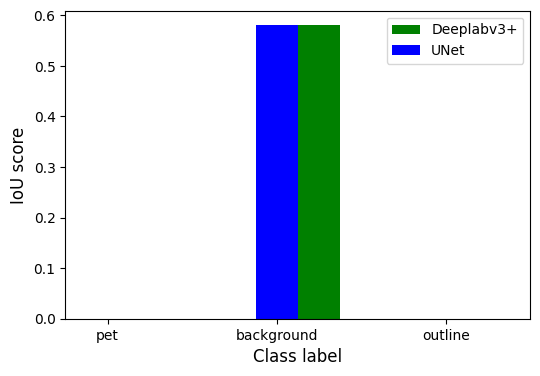

In [49]:
# Plot bar chart to show IoU scores for predictions from both models

fig = plt.figure(figsize =(6,4))
X = np.arange(3)
plt.bar(X + 0.25, deeplab_cls_wise_iou, color = 'g', width = 0.25, label = 'Deeplabv3+')
plt.bar(class_names, cls_wise_iou, color = 'b', width = 0.25, label = 'UNet')
plt.xlabel('Class label', fontsize = 12)
plt.ylabel('IoU score', fontsize = 12)
plt.legend()
plt.show()

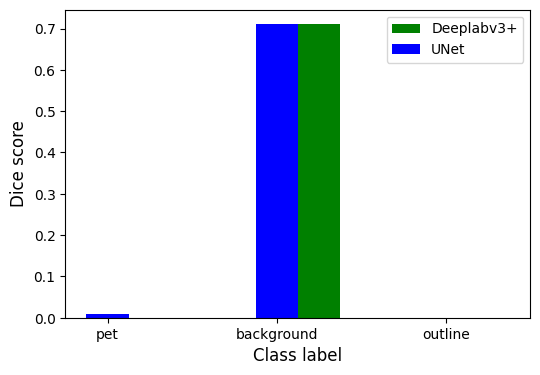

In [50]:
# Plot bar chart to show Dice scores for predictions from both models

fig = plt.figure(figsize =(6,4))
X = np.arange(3)
plt.bar(X + 0.25, deeplab_cls_wise_dice_score, color = 'g', width = 0.25, label = 'Deeplabv3+')
plt.bar(class_names, cls_wise_dice_score, color = 'b', width = 0.25, label = 'UNet')
plt.xlabel('Class label', fontsize = 12)
plt.ylabel('Dice score', fontsize = 12)
plt.legend()
plt.show()

### Show Predictions

In [51]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 360

# Get the prediction mask
y_pred_mask_deeplab = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider], model = deeplab_model)

1/1 [==============================] - 2s 2s/step


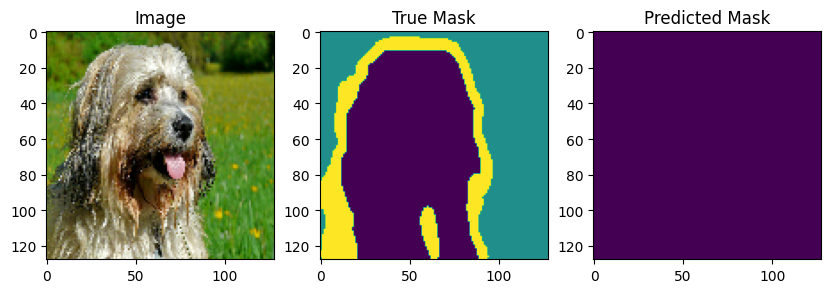

In [52]:
plt.figure(figsize=(10, 10))
# Original Image
img_arr = tf.keras.preprocessing.image.array_to_img(y_true_images[integer_slider])
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img_arr)

# Ground truth Mask
img_arr = tf.keras.preprocessing.image.array_to_img(y_true_segments[integer_slider])
plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(img_arr)
 # Predicted Mask
img_arr = tf.keras.preprocessing.image.array_to_img(y_pred_mask_deeplab)
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(img_arr)

In [53]:
# Compute the class wise metrics
dlab_iou, dlab_dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask_deeplab)
dlab_iou, dlab_dice_score

([1.3392259256204288e-09, 0.380249023815766, 3.7216226136151003e-09],
 [2.6784518476538053e-09, 0.5509861151932554, 7.443245199529251e-09])